In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics 

import warnings
warnings.simplefilter('ignore')

# https://qiita.com/shota-imazeki/items/6f48c78edf0ce3b316e1

In [26]:
class Adversarial_validator:

    def __init__(self, train, test, features, categoricals):
        self.train = train
        self.test = test
        self.features = features
        self.categoricals = categoricals
        self.union_df = self.train_test_union(self.train, self.test)
        self.cv = self.get_cv()
        self.models = []
        self.oof_pred = self.fit()
        self.report_plot()

    def fit(self):
        oof_pred = np.zeros((len(self.union_df), ))

        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_predict = self.union_df[self.features].iloc[
                train_idx], self.union_df[self.features].iloc[val_idx]
            y_train = self.union_df['target'][train_idx]
            train_set = self.convert_dataset(x_train, y_train)
            model = self.train_model(train_set)
            self.models.append(model)

            oof_pred[val_idx] = model.predict(
                x_predict).reshape(oof_pred[val_idx].shape)
        self.union_df['prediction'] = oof_pred
        return oof_pred

    def train_test_union(self, train, test):
        train['target'] = 0
        test['target'] = 1
        return pd.concat([train, test], axis=0).reset_index(drop=True)

    def get_cv(self):
        cv = StratifiedKFold(n_splits=5,
                             shuffle=True, random_state=42)

        return cv.split(self.union_df, self.union_df['target'])

    def convert_dataset(self, X, y):
        return lgb.Dataset(X, label=y, categorical_feature=self.categoricals)

    def train_model(self, train_set):
        return lgb.train(self.get_params(), train_set)

    def get_params(self):
        param = {'num_leaves': 50,
                 'num_round': 100,
                 'min_data_in_leaf': 30,
                 'objective': 'binary',
                 'max_depth': 5,
                 'learning_rate': 0.2,
                 'min_child_samples': 20,
                 'boosting': 'gbdt',
                 'feature_fraction': 0.9,
                 'bagging_freq': 1,
                 'bagging_fraction': 0.9,
                 'bagging_seed': 44,
                 'verbose_eval': 50,
                 'metric': 'auc',
                 'verbosity': -1}
        return param

    def report_plot(self):
        fig, ax = plt.subplots(figsize=(16, 12))
        plt.subplot(2, 2, 1)
        self.plot_feature_importance()
        plt.subplot(2, 2, 2)
        self.plot_roc_curve()
        plt.subplot(2, 2, 3)
        plt.hist(self.union_df['target'] - self.oof_pred)
        plt.title('Distribution of errors')
        plt.subplot(2, 2, 4)
        plt.hist(np.random.choice(self.oof_pred, 1000, False))
        plt.title('Distribution of oof predictions')

    def get_feature_importance(self):
        n = len(self.models)
        feature_imp_df = pd.DataFrame()
        for i in range(n):
            tmp = pd.DataFrame(zip(self.models[i].feature_importance(
            ), self.features), columns=['Value', 'Feature'])
            tmp['n_models'] = i
            feature_imp_df = pd.concat([feature_imp_df, tmp])
            del tmp
        self.feature_importance = feature_imp_df
        return feature_imp_df

    def plot_feature_importance(self, n=20):
        imp_df = self.get_feature_importance().groupby(
            ['Feature'])[['Value']].mean().reset_index(False)
        imp_top_df = imp_df.sort_values('Value', ascending=False).head(n)
        sns.barplot(data=imp_top_df, x='Value', y='Feature', orient='h')
        plt.title('Feature importances')

    def plot_roc_curve(self):
        fpr, tpr, thresholds = metrics.roc_curve(
            self.union_df['target'], self.oof_pred)
        auc = metrics.auc(fpr, tpr)

        plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % auc)
        plt.legend()
        plt.title('ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

In [39]:
train = pd.read_csv('train.csv').drop(['Name', 'Ticket'], axis=1)
test = pd.read_csv('test.csv').drop(['Name', 'Ticket'], axis=1)

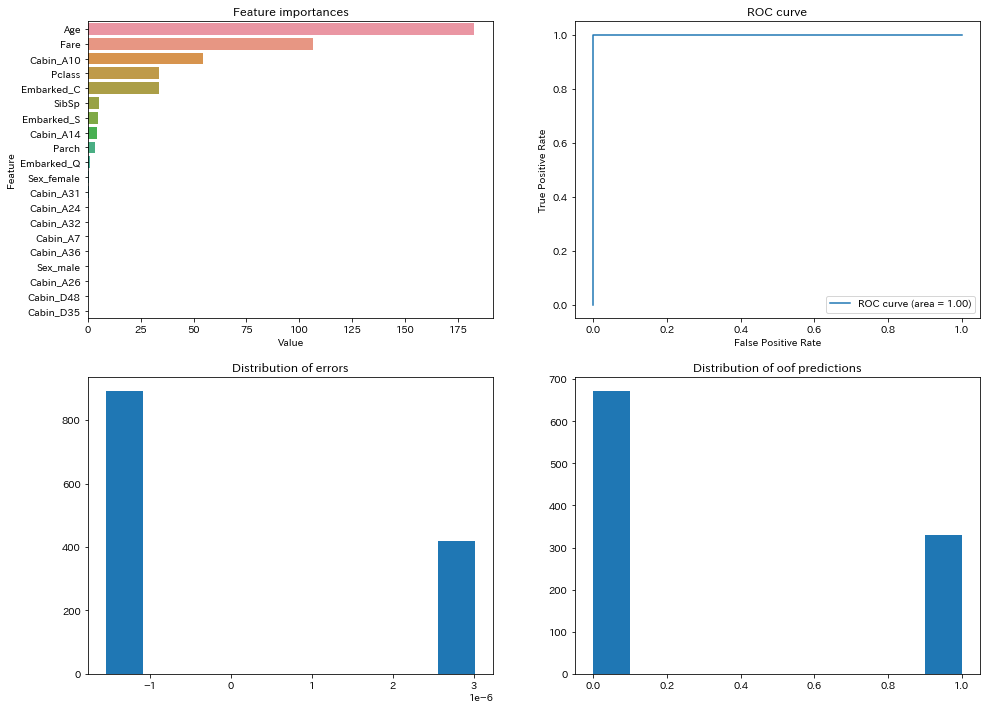

In [34]:
train_ = train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']]
features = train_.columns
test_ = test[features]

# カテゴリ変数に対しては一旦one-hotの処理
one_hot_train = pd.get_dummies(train_)
one_hot_test = pd.get_dummies(test_)
features_ = one_hot_train.columns

categoricals = []

adv = Adversarial_validator(one_hot_train, one_hot_test, features_, categoricals)

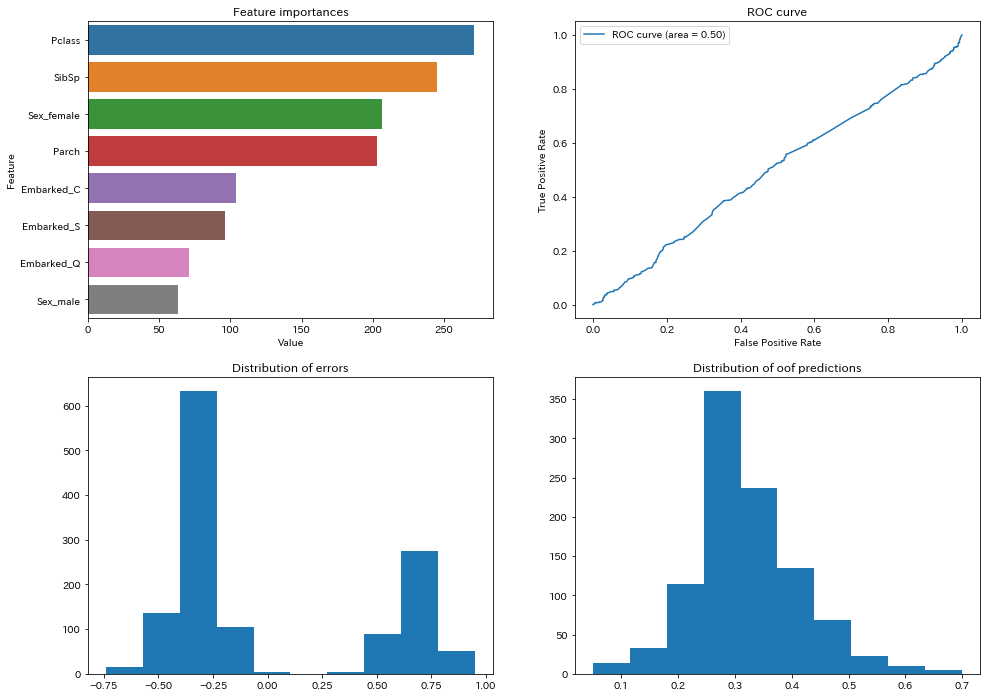

In [38]:
train_ = train[['Pclass', 'Sex','Parch', 'SibSp', 'Embarked']]
features = train_.columns
test_ = test[features]

# カテゴリ変数に対しては一旦one-hotの処理
one_hot_train = pd.get_dummies(train_)
one_hot_test = pd.get_dummies(test_)
features_ = one_hot_train.columns 

categoricals = []

adv = Adversarial_validator(one_hot_train, one_hot_test, features_, categoricals)